**Optimization Methods**

Until now, you've always used Gradient Descent to update the parameters and minimize the cost. In this notebook, you will learn more advanced optimization methods that can speed up learning and perhaps even get you to a better final value for the cost function. Having a good optimization algorithm can be the difference between waiting days vs. just a few hours to get a good result. 

**Minimizing the cost is like finding the lowest point in a hilly landscape**<br> At each step of the training, you update your parameters following a certain direction to try to get to the lowest possible point. </center></caption>

**Notations**: As usual, $\frac{\partial J}{\partial a } = $ `da` for any variable `a`.

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/11 - Deep Learning/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/11 - Deep Learning


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from lib.opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from lib.opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from lib.testCases import *

plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Gradient Descent

A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all $m$ examples on each step, it is also called Batch Gradient Descent. 

**Warm-up exercise**: Implement the gradient descent update rule. The  gradient descent rule is, for $l = 1, ..., L$: 
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

where L is the number of layers and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary. Note that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$. You need to shift `l` to `l+1` when coding.

In [3]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural networks
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads['db' + str(l+1)]        
    return parameters

In [4]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()
parameters = update_parameters_with_gd(parameters, grads, learning_rate)
parameters

{'W1': array([[ 1.63535156, -0.62320365, -0.53718766],
        [-1.07799357,  0.85639907, -2.29470142]]),
 'W2': array([[ 0.32171798, -0.25467393,  1.46902454],
        [-2.05617317, -0.31554548, -0.3756023 ],
        [ 1.1404819 , -1.09976462, -0.1612551 ]]),
 'b1': array([[ 1.74604067],
        [-0.75184921]]),
 'b2': array([[-0.88020257],
        [ 0.02561572],
        [ 0.57539477]])}

# Stochastic Gradient Descent (SGD)
A variant of this is Stochastic Gradient Descent (SGD), which is equivalent to mini-batch gradient descent where each mini-batch has just 1 example. The update rule that you have just implemented does not change. What changes is that you would be computing gradients on just one training example at a time, rather than on the whole training set. The code examples below illustrate the difference between stochastic gradient descent and (batch) gradient descent. 

In Stochastic Gradient Descent, you use only 1 training example before updating the gradients. When the training set is large, SGD can be faster. But the parameters will "oscillate" toward the minimum rather than converge smoothly. Here is an illustration of this: 

<img src="https://raw.githubusercontent.com/sebastianbirk/coursera-deep-learning-specialization/master/02_improving_dnns_with_hyperparameter_tuning_regularization_and_optimization/04_optimization_methods_with_numpy/images/kiank_sgd.png" style="width:750px;height:250px;">
<caption><center> <u> **Figure 1** </u>: **SGD vs GD**<br> "+" denotes a minimum of the cost. SGD leads to many oscillations to reach convergence. But each step is a lot faster to compute for SGD than for GD, as it uses only one training example (vs. the whole batch for GD). </center></caption>

**Note** also that implementing SGD requires 3 for-loops in total:
1. Over the number of iterations
2. Over the $m$ training examples
3. Over the layers (to update all parameters, from $(W^{[1]},b^{[1]})$ to $(W^{[L]},b^{[L]})$)

In practice, you'll often get faster results if you do not use neither the whole training set, nor only one training example, to perform each update. Mini-batch gradient descent uses an intermediate number of examples for each step. With mini-batch gradient descent, you loop over the mini-batches instead of looping over individual training examples.

<img src="https://raw.githubusercontent.com/sebastianbirk/coursera-deep-learning-specialization/master/02_improving_dnns_with_hyperparameter_tuning_regularization_and_optimization/04_optimization_methods_with_numpy/images/kiank_minibatch.png" style="width:750px;height:250px;">
<caption><center> <u>**Figure 2** </u>: **SGD vs Mini-Batch GD**<br> "+" denotes a minimum of the cost. Using mini-batches in your optimization algorithm often leads to faster optimization. </center></caption>

**What you should remember**:
    
- The difference between gradient descent, mini-batch gradient descent and stochastic gradient descent is the number of examples you use to perform one update step.
- You have to tune a learning rate hyperparameter $\alpha$.
- With a well-turned mini-batch size, usually it outperforms either gradient descent or stochastic gradient descent (particularly when the training set is large).

# Mini-Batch Gradient descent

There are two steps:
- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches. 

<img src="https://github.com/sebastianbirk/coursera-deep-learning-specialization/blob/master/02_improving_dnns_with_hyperparameter_tuning_regularization_and_optimization/04_optimization_methods_with_numpy/images/kiank_shuffle.png?raw=true" style="width:550px;height:300px;">

- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full `mini_batch_size`, it will look like this: 

<img src="https://github.com/sebastianbirk/coursera-deep-learning-specialization/blob/master/02_improving_dnns_with_hyperparameter_tuning_regularization_and_optimization/04_optimization_methods_with_numpy/images/kiank_partition.png?raw=true" style="width:550px;height:300px;">

In [5]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):   
    m = X.shape[1]                  
    mini_batches = []
        
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Partition (shuffled_X, shuffled_Y)
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, int(m/mini_batch_size)*mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, int(m/mini_batch_size)*mini_batch_size : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [6]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [-0.67124613  0.74055645 -0.63699565]


**What you should remember**:
    
- Shuffling and Partitioning are the two steps required to build mini-batches
- Powers of two are often chosen to be the mini-batch size, e.g., 16, 32, 64, 128.

# Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations. 

Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill. 

<img src="https://github.com/sebastianbirk/coursera-deep-learning-specialization/blob/master/02_improving_dnns_with_hyperparameter_tuning_regularization_and_optimization/04_optimization_methods_with_numpy/images/Momentum.png?raw=true" style="width:400px;height:250px;">
<caption><center> <u>**Figure 3**</u>: The red arrows shows the direction taken by one step of mini-batch gradient descent with momentum. The blue points show the direction of the gradient (with respect to the current mini-batch) on each step. Rather than just following the gradient, we let the gradient influence $v$ and then take a step in the direction of $v$.<br> <font color='black'> </center>

**Note** that the iterator l starts at 0 in the for loop while the first parameters are v["dW1"] and v["db1"] (that's a "one" on the superscript). This is why we are shifting l to l+1 in the `for` loop.

In [7]:
def initialize_velocity(parameters):
    L = len(parameters) // 2
    v = {}
    
    # Initialize velocity
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))        
    return v

In [8]:
parameters = initialize_velocity_test_case()
v = initialize_velocity(parameters)
parameters

{'W1': array([[ 1.62434536, -0.61175641, -0.52817175],
        [-1.07296862,  0.86540763, -2.3015387 ]]),
 'W2': array([[ 0.3190391 , -0.24937038,  1.46210794],
        [-2.06014071, -0.3224172 , -0.38405435],
        [ 1.13376944, -1.09989127, -0.17242821]]),
 'b1': array([[ 1.74481176],
        [-0.7612069 ]]),
 'b2': array([[-0.87785842],
        [ 0.04221375],
        [ 0.58281521]])}

Implement the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  Note that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript). So you will need to shift `l` to `l+1` when coding.

In [9]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):

    L = len(parameters) // 2 
    # Momentum update for each parameter
    for l in range(L):
        # compute velocities
        # bv is always 0 to save memory, supposed to be b*v(t-1)
        v["dW" + str(l+1)] = beta*v["dW" + str(l+1)] + (1 - beta)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta*v["db" + str(l+1)] + (1 - beta)*grads['db' + str(l+1)]
                
        # learning rate decay
        # lr = learning_rate * k / np.sqrt(epoch_num)
        
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v["db" + str(l+1)]
        
    return parameters, v

In [10]:
parameters, grads, v = update_parameters_with_momentum_test_case()
parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
parameters

{'W1': array([[ 1.62544598, -0.61290114, -0.52907334],
        [-1.07347112,  0.86450677, -2.30085497]]),
 'W2': array([[ 0.31930698, -0.24990073,  1.4627996 ],
        [-2.05974396, -0.32173003, -0.38320915],
        [ 1.13444069, -1.0998786 , -0.1713109 ]]),
 'b1': array([[ 1.74493465],
        [-0.76027113]]),
 'b2': array([[-0.87809283],
        [ 0.04055394],
        [ 0.58207317]])}

**Note** that:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update because the more we take the past gradients into account. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might need trying several values to see what works best in term of reducing the value of the cost function $J$. 

**What you should remember**:
    
- Momentum takes past gradients into account to smooth out the steps of gradient descent. It can be applied with batch gradient descent, mini-batch gradient descent or stochastic gradient descent.
- You have to tune a momentum hyperparameter $\beta$ and a learning rate $\alpha$.

# Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, we will store all parameters in the `parameters` dictionary  

In [11]:
def initialize_adam(parameters) :    
    L = len(parameters) // 2
    v, s = {}, {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
    
    return v, s

In [12]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print(v)
print(s)

{'dW1': array([[0., 0., 0.],
       [0., 0., 0.]]), 'db1': array([[0.],
       [0.]]), 'dW2': array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), 'db2': array([[0.],
       [0.],
       [0.]])}
{'dW1': array([[0., 0., 0.],
       [0., 0., 0.]]), 'db1': array([[0.],
       [0.]]), 'dW2': array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), 'db2': array([[0.],
       [0.],
       [0.]])}


**Exercise**:  Now, implement the parameters update with Adam. Recall the general update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$


**Note** that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$. You need to shift `l` to `l+1` when coding.

In [14]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    L = len(parameters) // 2                 
    v_corrected = {}                         
    s_corrected = {}                         
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1 - beta1)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1 - beta1)*grads['db' + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1 - beta1**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1 - beta2)*np.square(grads['dW' + str(l+1)])
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1 - beta2)*np.square(grads['db' + str(l+1)])

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1 - beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1 - beta2**t)
    
        # learning rate decay
        # lr = learning_rate * k / np.sqrt(epoch_num)
        
        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon)

    return parameters, v, s

In [15]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

parameters

{'W1': array([[ 1.63178673, -0.61919778, -0.53561312],
        [-1.08040999,  0.85796626, -2.29409733]]),
 'W2': array([[ 0.32648046, -0.25681174,  1.46954931],
        [-2.05269934, -0.31497584, -0.37661299],
        [ 1.14121081, -1.09244991, -0.16498684]]),
 'b1': array([[ 1.75225313],
        [-0.75376553]]),
 'b2': array([[-0.88529979],
        [ 0.03477238],
        [ 0.57537385]])}

# Model with different optimization algorithms

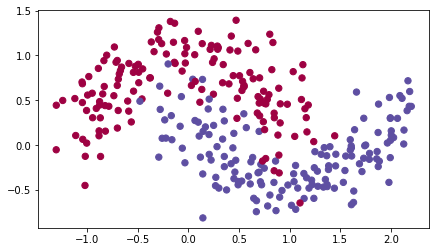

In [18]:
train_X, train_Y = load_dataset()

In [19]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):

    L = len(layers_dims)           
    costs = []                      
    t = 0                            
    seed = 10                       
    m = X.shape[1] 
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

## Mini-batch Gradient descent

Cost after epoch 0: 0.702401
Cost after epoch 1000: 0.668070
Cost after epoch 2000: 0.635231
Cost after epoch 3000: 0.600410
Cost after epoch 4000: 0.573274
Cost after epoch 5000: 0.551821
Cost after epoch 6000: 0.532218
Cost after epoch 7000: 0.513848
Cost after epoch 8000: 0.495959
Cost after epoch 9000: 0.467688


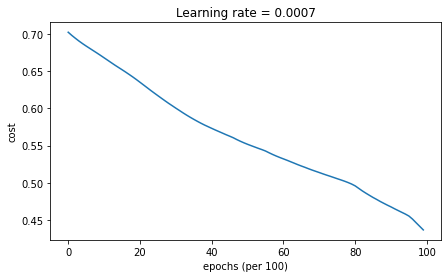

Accuracy: 0.7966666666666666


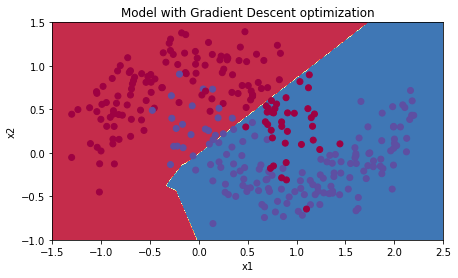

In [20]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Mini-batch gradient descent with momentum

Cost after epoch 0: 0.702411
Cost after epoch 1000: 0.668137
Cost after epoch 2000: 0.635331
Cost after epoch 3000: 0.600516
Cost after epoch 4000: 0.573359
Cost after epoch 5000: 0.551902
Cost after epoch 6000: 0.532308
Cost after epoch 7000: 0.513942
Cost after epoch 8000: 0.496227
Cost after epoch 9000: 0.467880


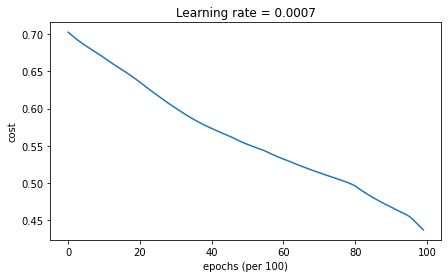

Accuracy: 0.7966666666666666


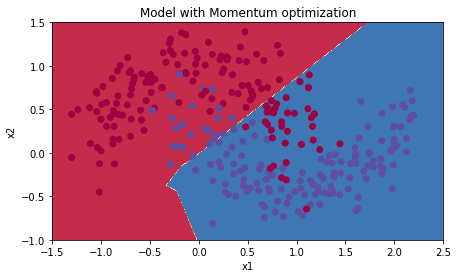

In [21]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Mini-batch with Adam mode

Cost after epoch 0: 0.701915
Cost after epoch 1000: 0.170363
Cost after epoch 2000: 0.141344
Cost after epoch 3000: 0.138694
Cost after epoch 4000: 0.136069
Cost after epoch 5000: 0.134390
Cost after epoch 6000: 0.131207
Cost after epoch 7000: 0.130331
Cost after epoch 8000: 0.129668
Cost after epoch 9000: 0.129212


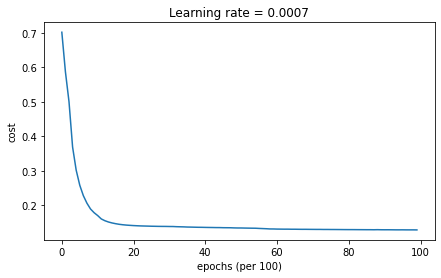

Accuracy: 0.94


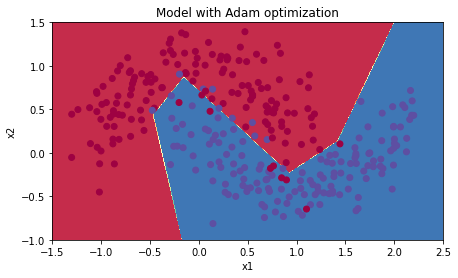

In [22]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

# Summary

<table> 
    <tr>
        <th>
        **optimization method**
        </th>
        <th>
        **accuracy**
        </th>
        <th>
        **cost shape**
        </th>
    </tr>
    <tr>
        <td>
        Gradient descent
        </td>
        <td>
        79.7%
        </td>
        <td>
        oscillations
        </td>
    <tr>
        <td>
        Momentum
        </td>
        <td>
        79.7%
        </td>
        <td>
        oscillations
        </td>
    </tr>
    <tr>
        <td>
        Adam
        </td>
        <td>
        94%
        </td>
        <td>
        smoother
        </td>
    </tr>
</table> 

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligeable. Also, the huge oscillations you see in the cost come from the fact that some minibatches are more difficult thans others for the optimization algorithm.

Adam on the other hand, clearly outperforms mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:
- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)

**References**:

- Adam paper: https://arxiv.org/pdf/1412.6980.pdf